# Analyzing Attention Patterns in Transformer-based Decision Making

This notebook explores the attention mechanisms in transformer models trained on decision sequences. We'll visualize and analyze what is represented in the attention matrices that lead to decision-making outputs (R, r, L, l).


In [2]:

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os

sys.path.append(os.path.abspath('../'))
from utils.parse_data import load_trained_model, parse_simulated_data, get_data_filenames, add_sequence_columns
# import interpretability.interp_helpers as interp
# import utils.file_management as fm

%load_ext autoreload
%autoreload 2

# Set plot style
sns.set_theme(
    style='ticks',
    font_scale=1.0,
    rc={'axes.labelsize': 11,
        'axes.titlesize': 11,
        'savefig.transparent': True,
        'legend.title_fontsize': 11,
        'legend.fontsize': 10,
        'legend.borderpad': 0.2,
        'figure.titlesize': 11,
        'figure.subplot.wspace': 0.1,
        })


## 1. Helper Functions for Extracting Attention Patterns


In [33]:

# Choose a run number based on available models
run = 36  # You may need to change this based on available models

# Load the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

model, model_info, config = load_trained_model(run, model_name=None, device=device, weights_only=False)

# Print number of parameters and important metadata
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")
print(f"Number of layers: {config.n_layer}")
print(f"Number of attention heads: {config.n_head}")
print(f"Embedding dimension: {config.n_embd}")
print(f"Vocabulary size: {config.vocab_size}")
print(f"Block size (context length): {config.block_size}")




Using cpu device
Total number of parameters: 292
Number of layers: 1
Number of attention heads: 1
Embedding dimension: 4
Vocabulary size: 4
Block size (context length): 6


In [4]:
import interpretability.interp_helpers as interp

vocab = ['R', 'r', 'L', 'l']
stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for i, ch in enumerate(vocab)}
T = model_info['dataloader']['Sequence length (T)']

# Get common sequences from data for analysis
num_sequences = 200
events, sequences, counts = interp.get_common_sequences(T, run=run, k=num_sequences)
block_sequences  = interp.get_block_transition_sequences(events, T, high_port=1)
print(f"Analyzing {num_sequences} sequences:\n{sequences[:20]}")

Analyzing 200 sequences:
['LLLLLL', 'RRRRRR', 'LLLLLl', 'RRRRRr', 'LLLLlL', 'RRRRrR', 'LLLlLL', 'LLlLLL', 'RRRrRR', 'LlLLLL', 'RRrRRR', 'lLLLLL', 'RrRRRR', 'rRRRRR', 'rLLLLL', 'lRRRRR', 'rrLLLL', 'llRRRR', 'RRRRrr', 'LLLLll']


In [5]:
block_sequences  = interp.get_block_transition_sequences(events, T, high_port=1)
block_sequences = [list(b.values) for b in block_sequences]

In [238]:
from attention_helpers import AttentionAnalyzer
from analyzer import DimensionalityReductionConfig
analyzer = AttentionAnalyzer(model, config)

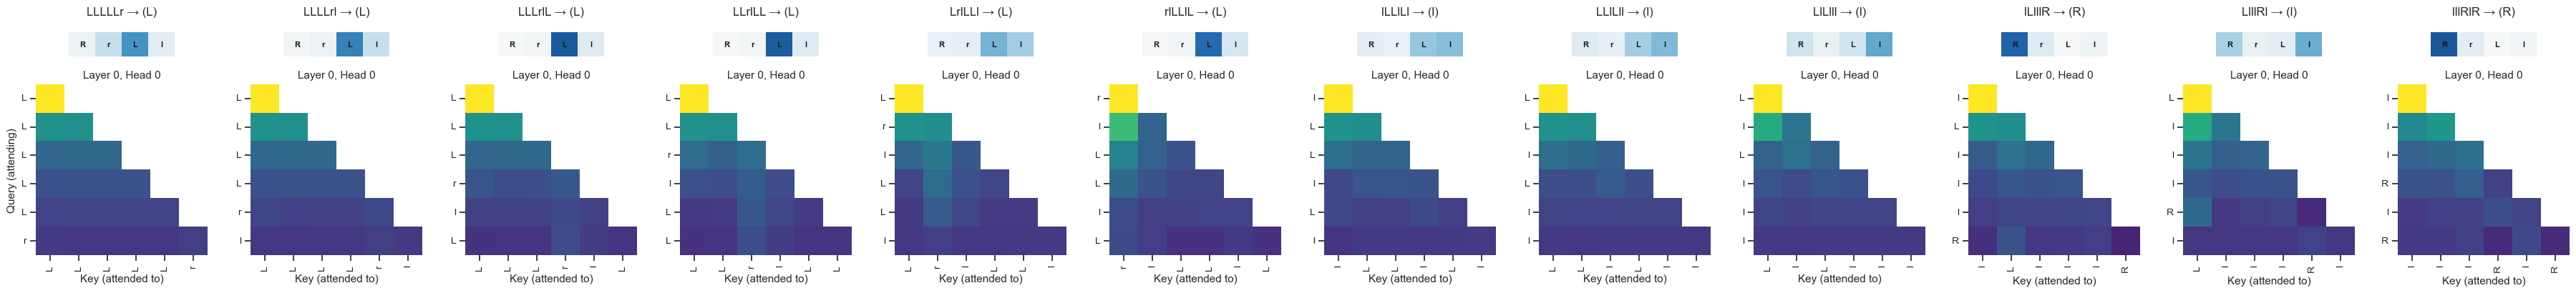

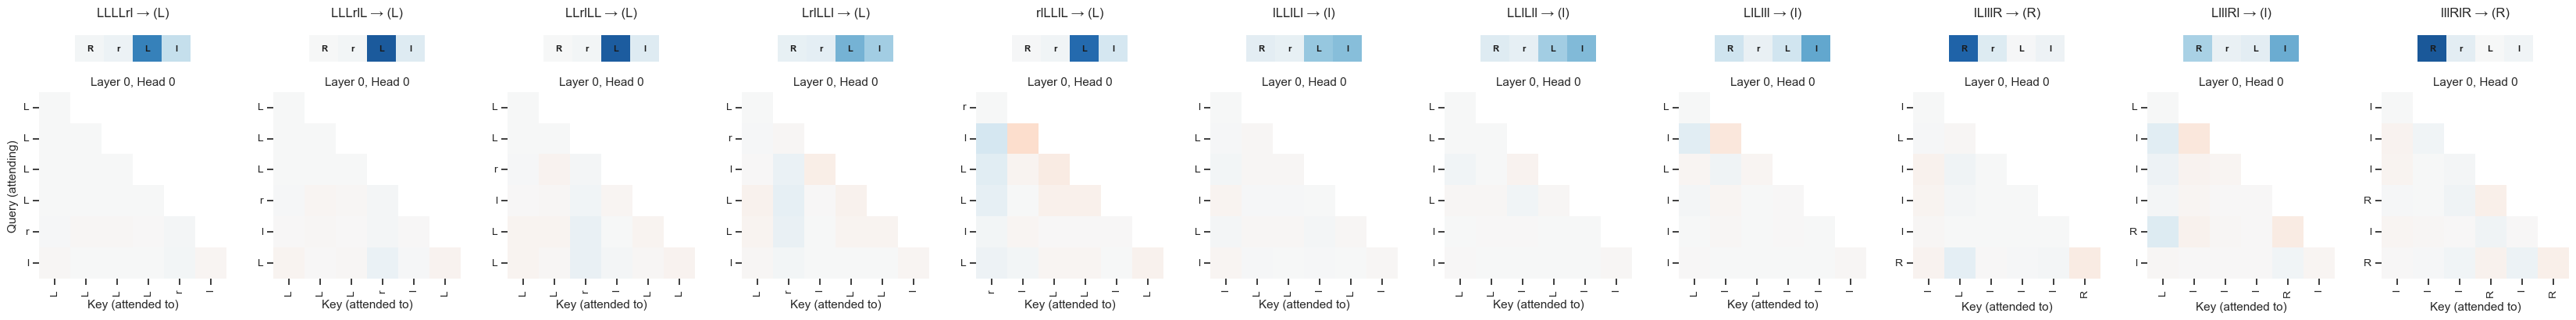

In [242]:
seq_ = interp.trim_leading_duplicates(block_sequences[12])
fig = analyzer.plot_attention_multiple_sequences(seq_, max_sequences=12)
fig = analyzer.plot_attention_multiple_sequences(
        seq_[1:],
        max_sequences=11,
        as_diff=True,
        ref_seq=seq_[0])

/Users/celiaberon/GitHub/Transformers_for_Modeling_Decision_Sequences/interpretability/analyzer.py:130: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.98])
/Users/celiaberon/GitHub/Transformers_for_Modeling_Decision_Sequences/interpretability/analyzer.py:130: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.98])
/Users/celiaberon/GitHub/Transformers_for_Modeling_Decision_Sequences/interpretability/analyzer.py:130: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.98])
/Users/celiaberon/GitHub/Transformers_for_Modeling_Decision_Sequences/interpretability/analyzer.py:130: UserWarning: Tight layout not applied. The bottom and top margins ca

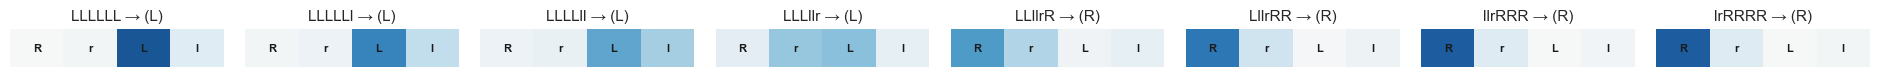

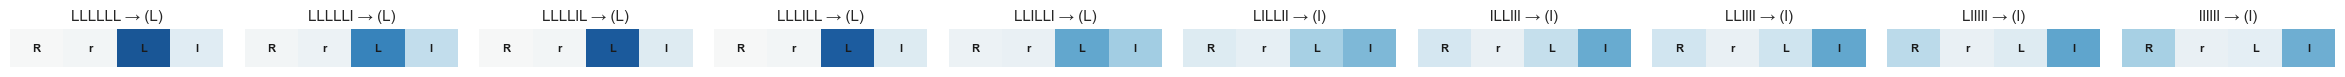

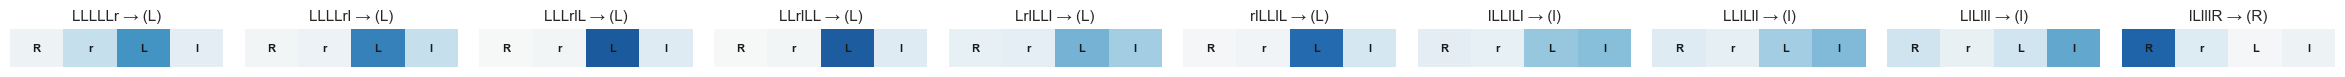

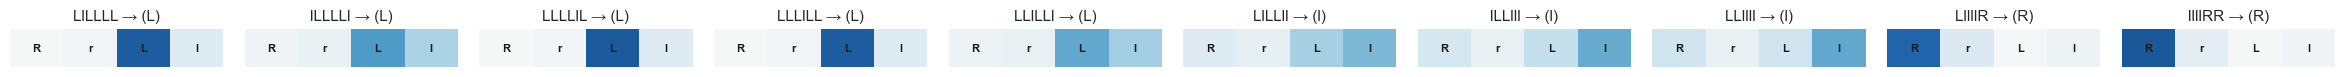

In [225]:
for seq in block_sequences[10:14]:
    seq_ = interp.trim_leading_duplicates(seq)
    fig = analyzer.visualizer.plot_multi_trial_token_probs(seq_, max_sequences=10)

## 2. Visualizing Attention Patterns for Specific Sequences

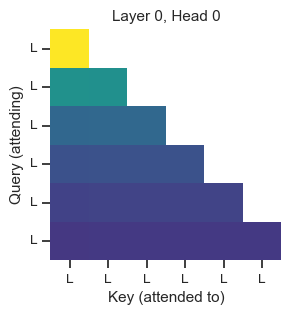

In [226]:
fig = analyzer.plot_attention(block_sequences[10][4], layer_idx=0, head_idx=0)

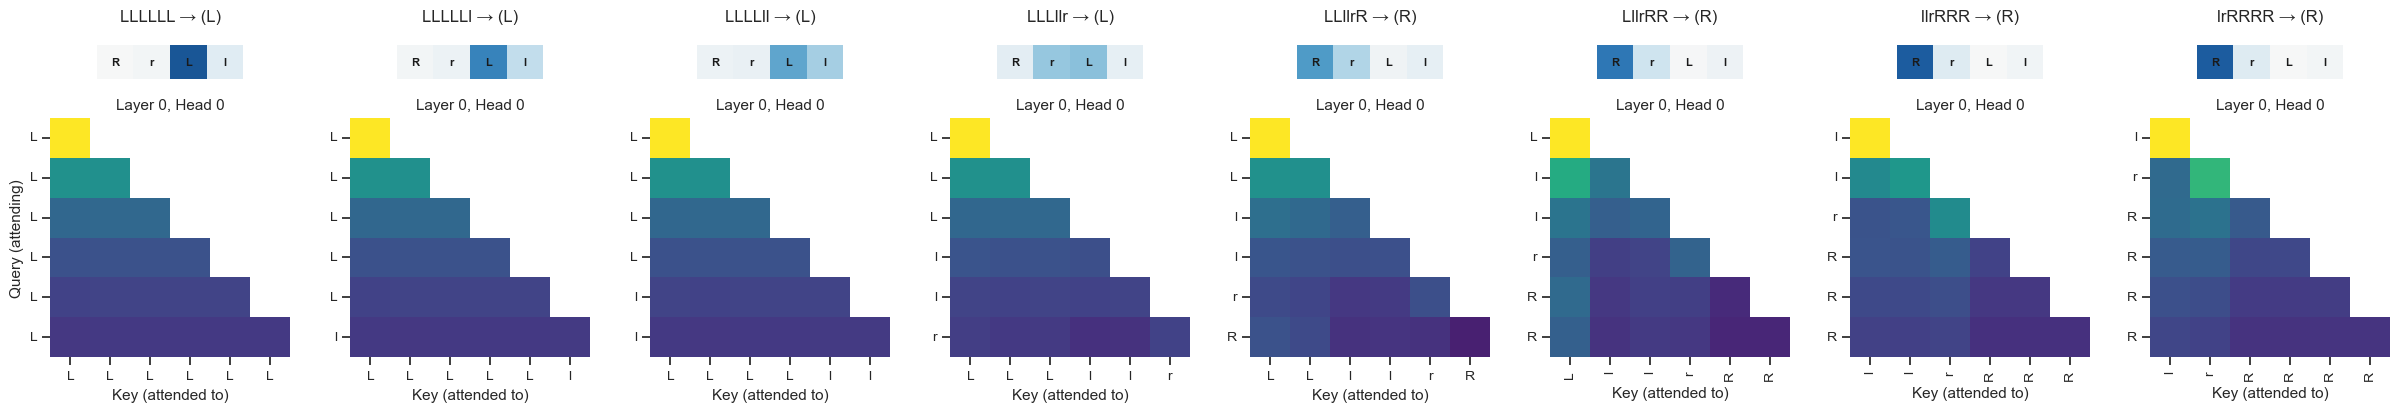

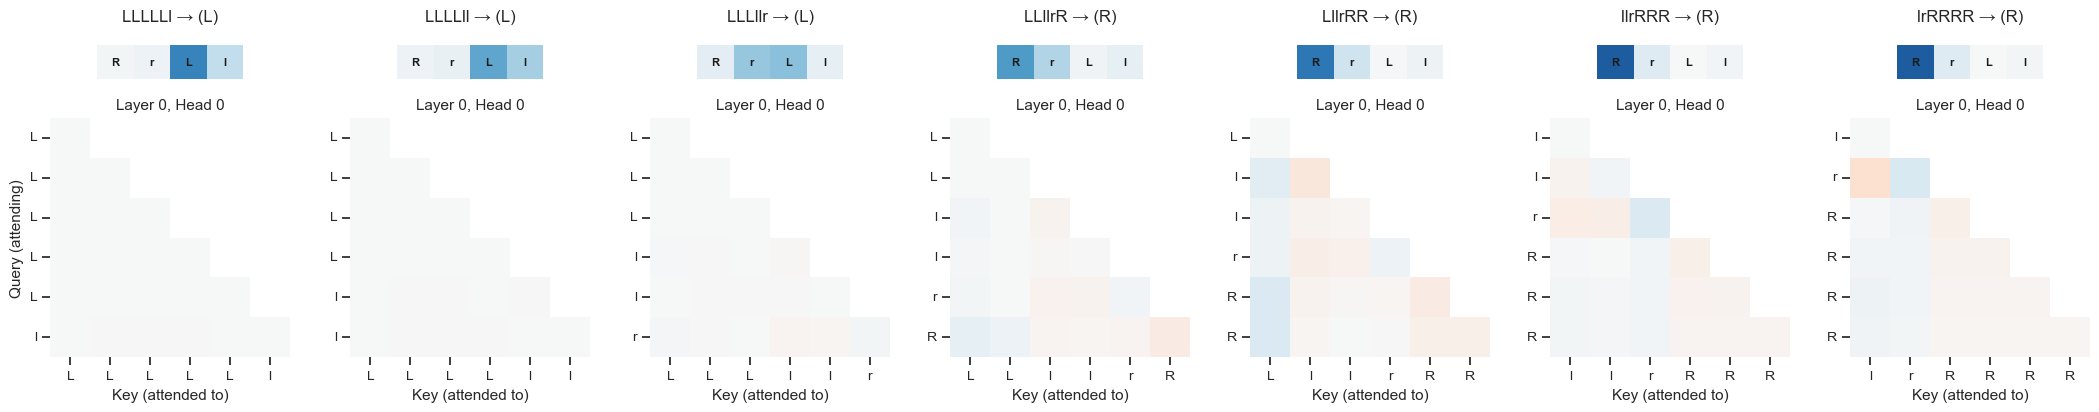

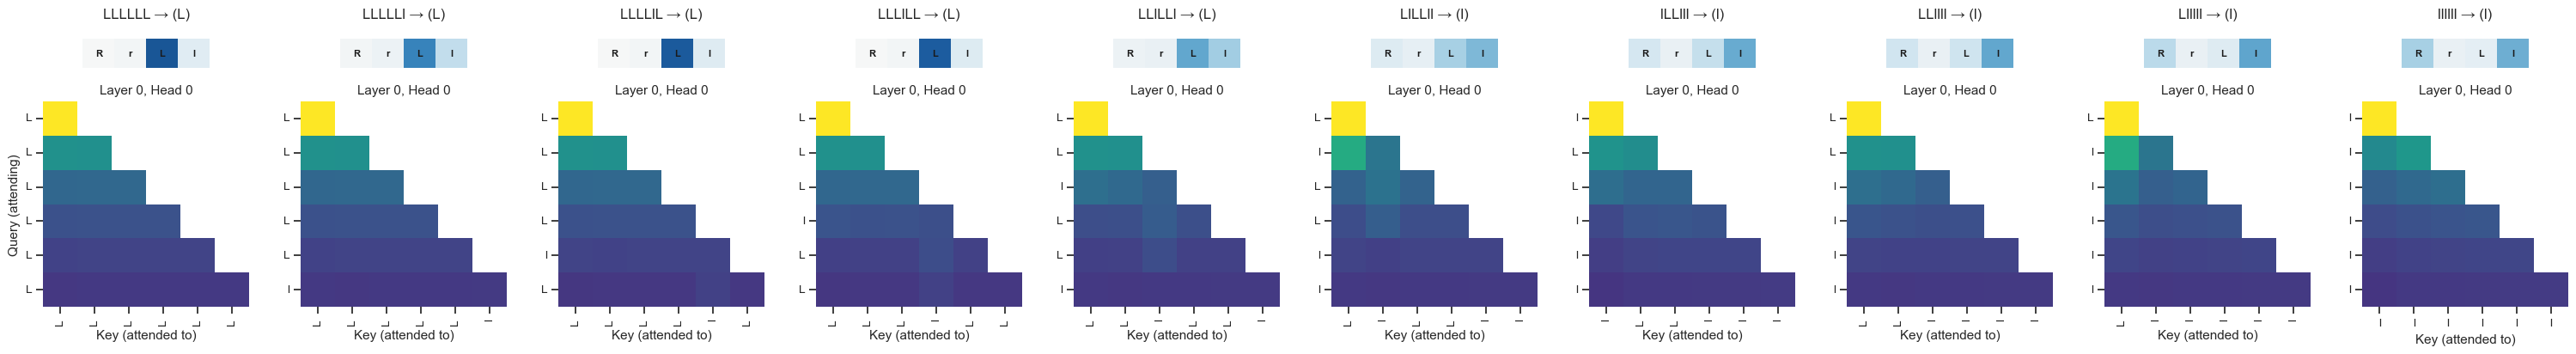

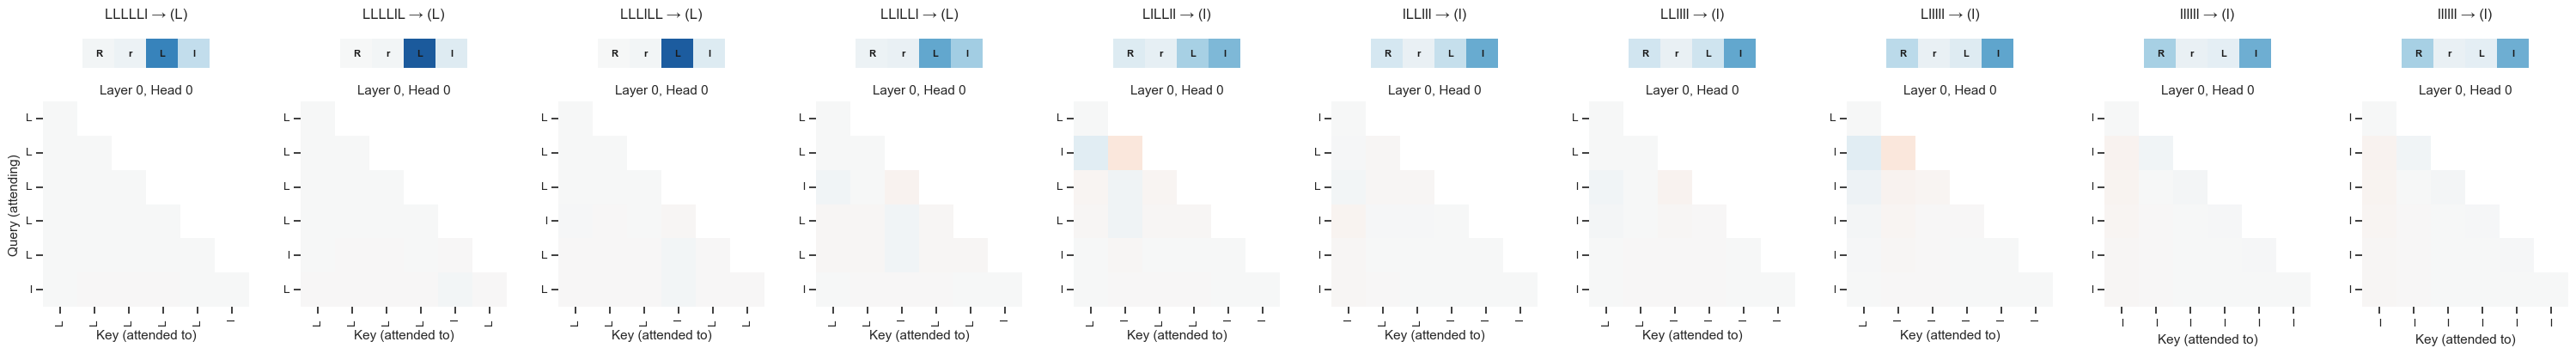

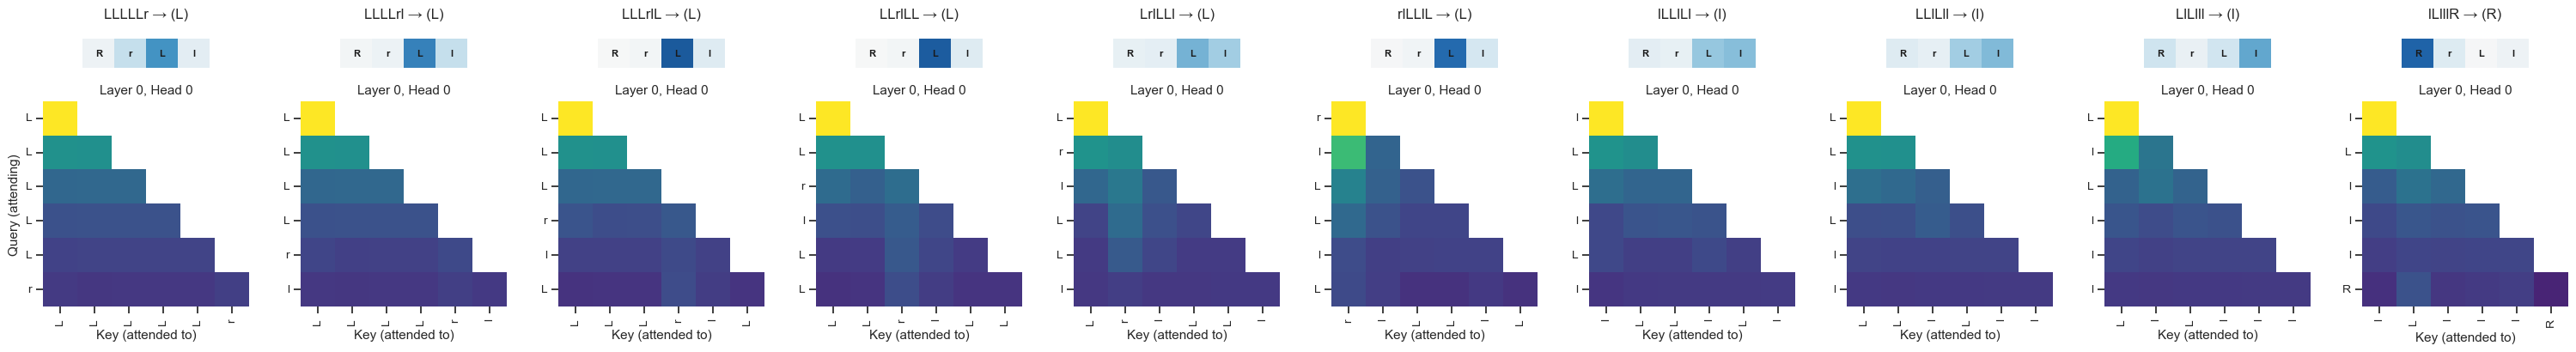

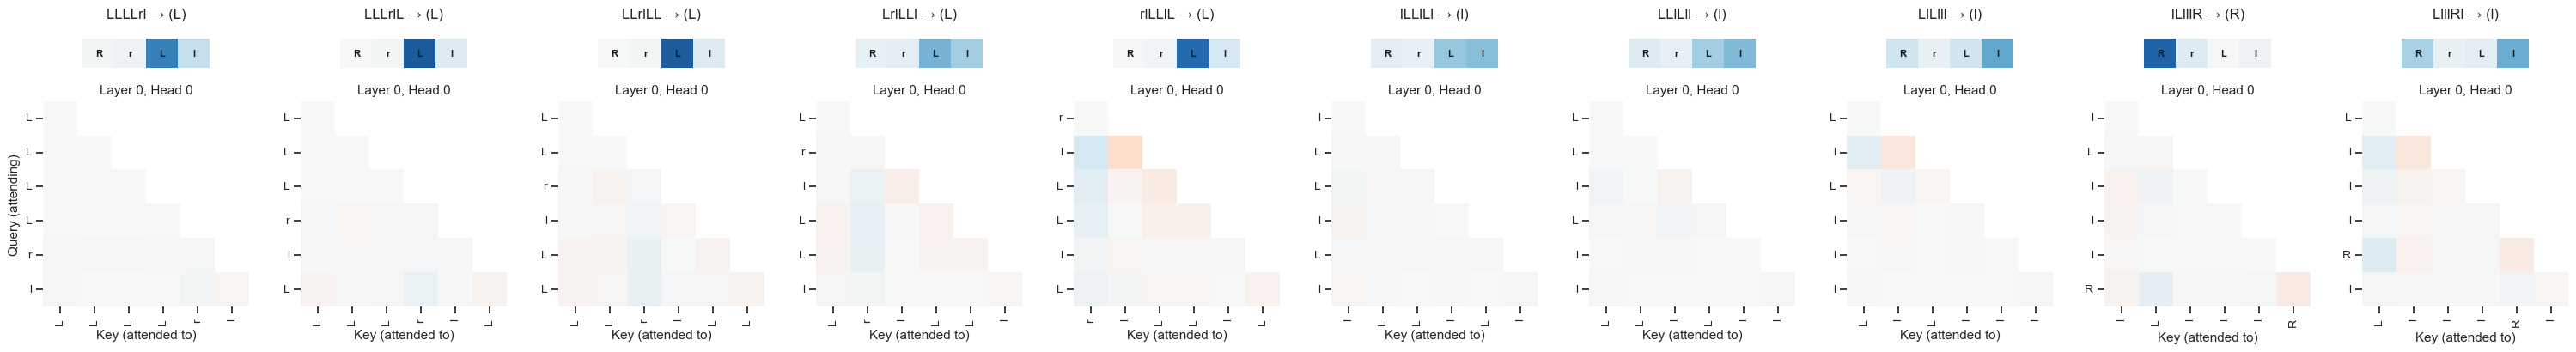

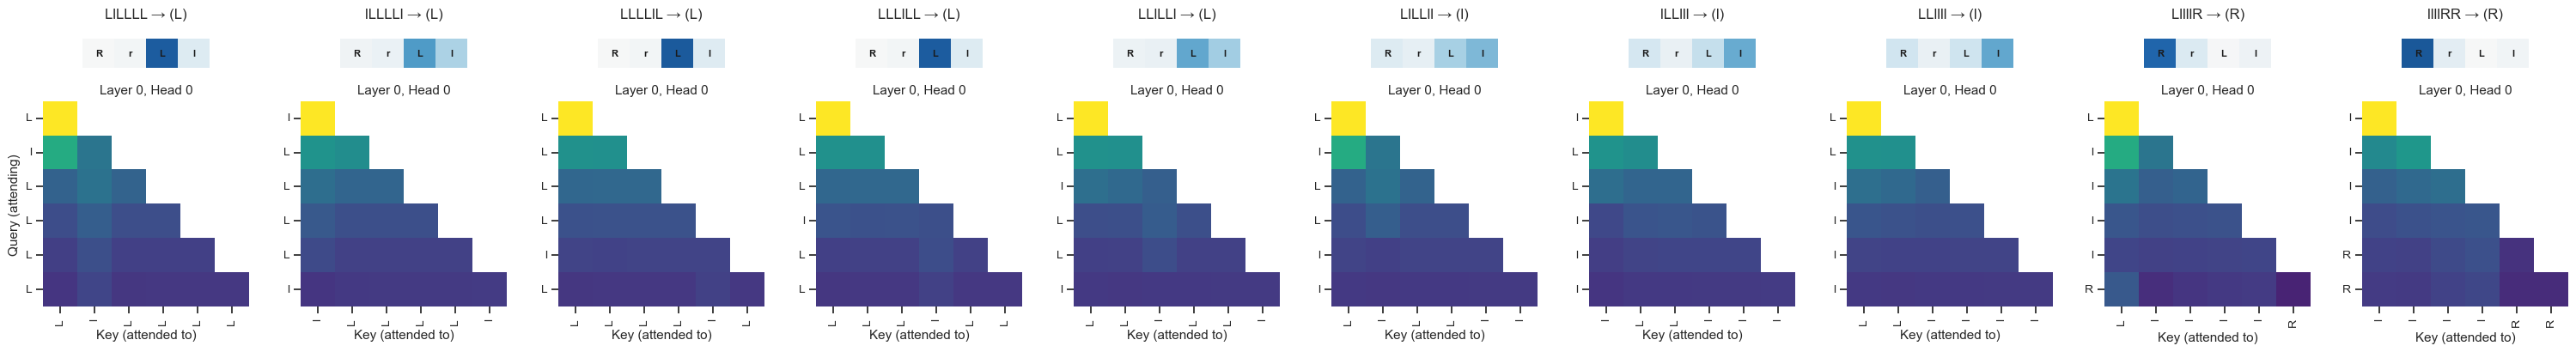

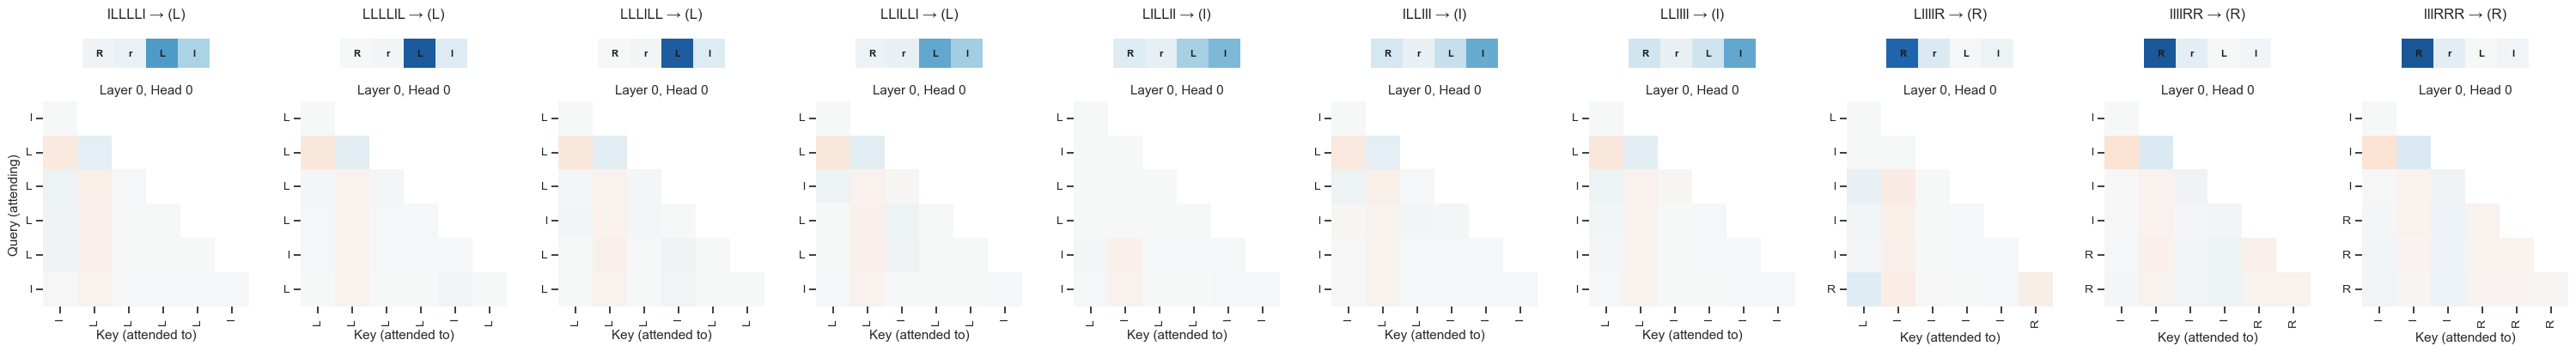

In [239]:
for seq in block_sequences[10:14]:
    seq_ = interp.trim_leading_duplicates(seq)
    fig = analyzer.plot_attention_multiple_sequences(seq_, max_sequences=10)
    fig = analyzer.plot_attention_multiple_sequences(
        seq_[1:],
        max_sequences=10,
        as_diff=True,
        ref_seq=seq_[0])

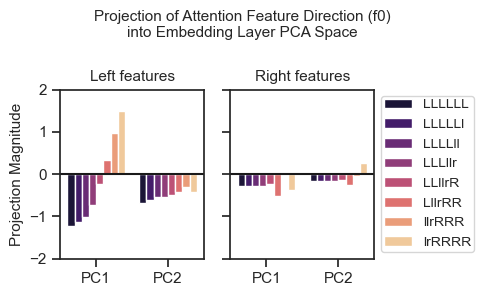

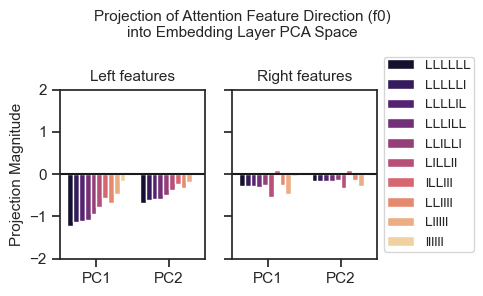

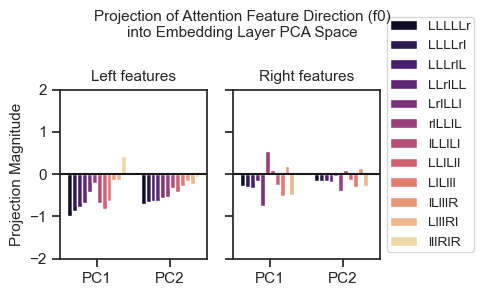

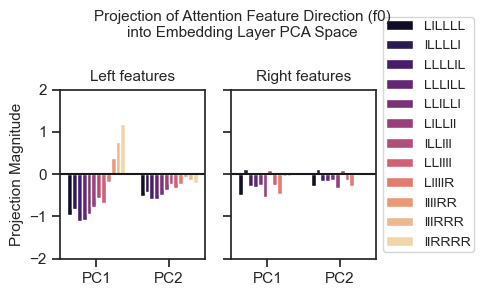

In [176]:
dr_config = DimensionalityReductionConfig(
    token_pos=1,
    sequence_method='token',
    n_components=2
)
for trial in range(10, 14):
    analyzer.plot_attention_features(sequences, block_sequences[trial], dr_config)

## 5. Analyzing How Attention Heads Specialize


Analyzing sequence 1/5: RRRRRR


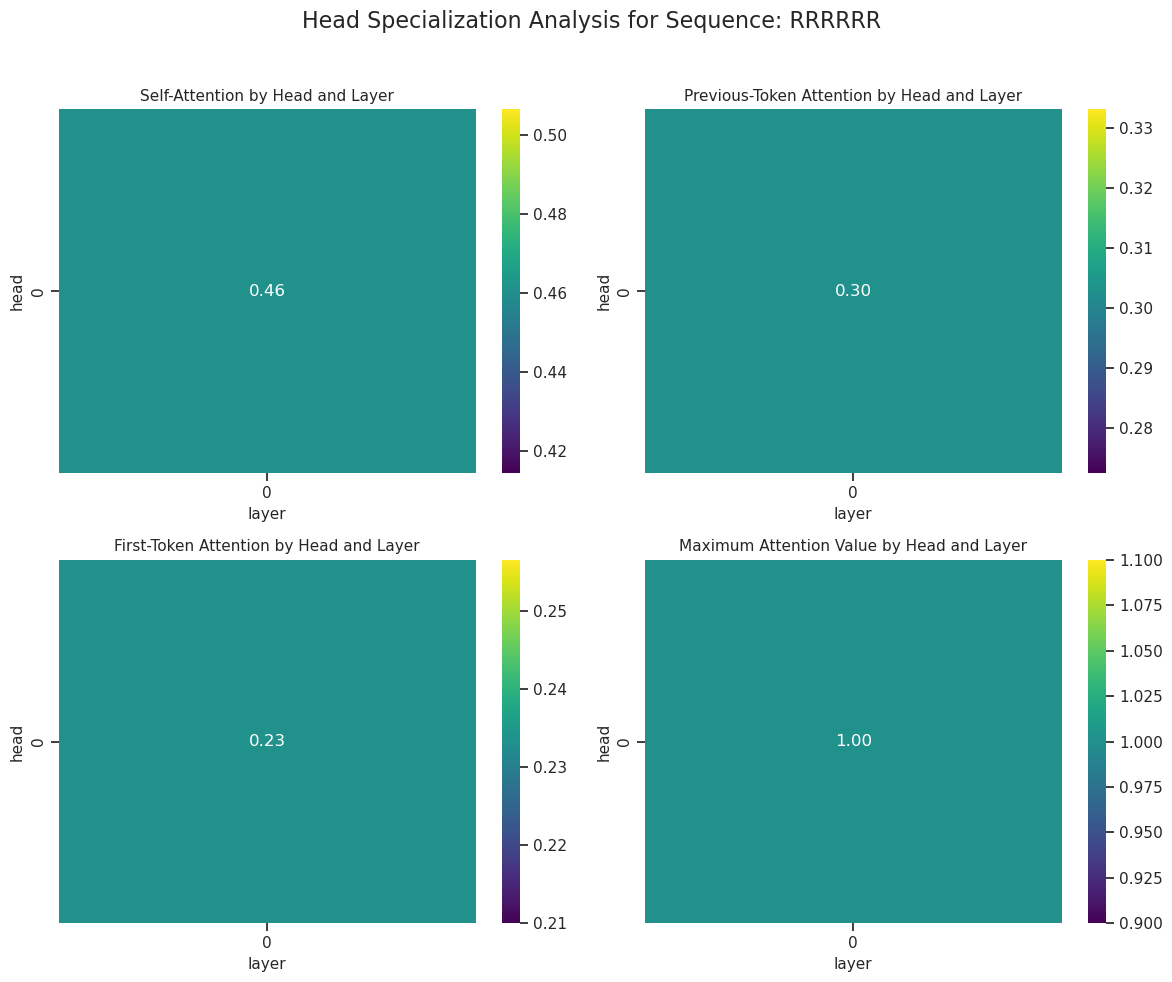


Top specialization patterns for sequence 'RRRRRR':
   layer  head  max_attention max_attention_pos
0      0     0            1.0            (0, 0)

Analyzing sequence 2/5: LLLLLL


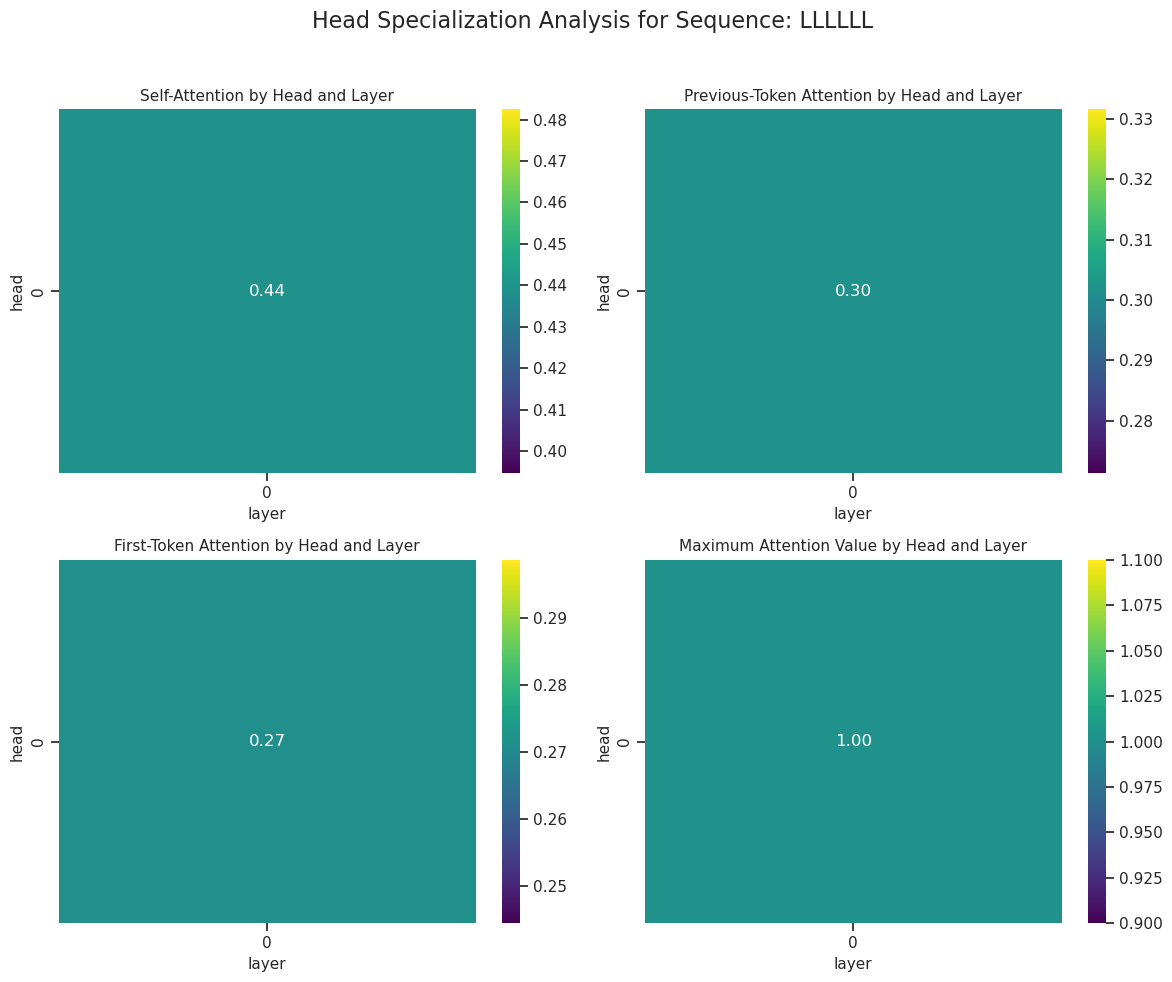


Top specialization patterns for sequence 'LLLLLL':
   layer  head  max_attention max_attention_pos
0      0     0            1.0            (0, 0)

Analyzing sequence 3/5: RRRRRr


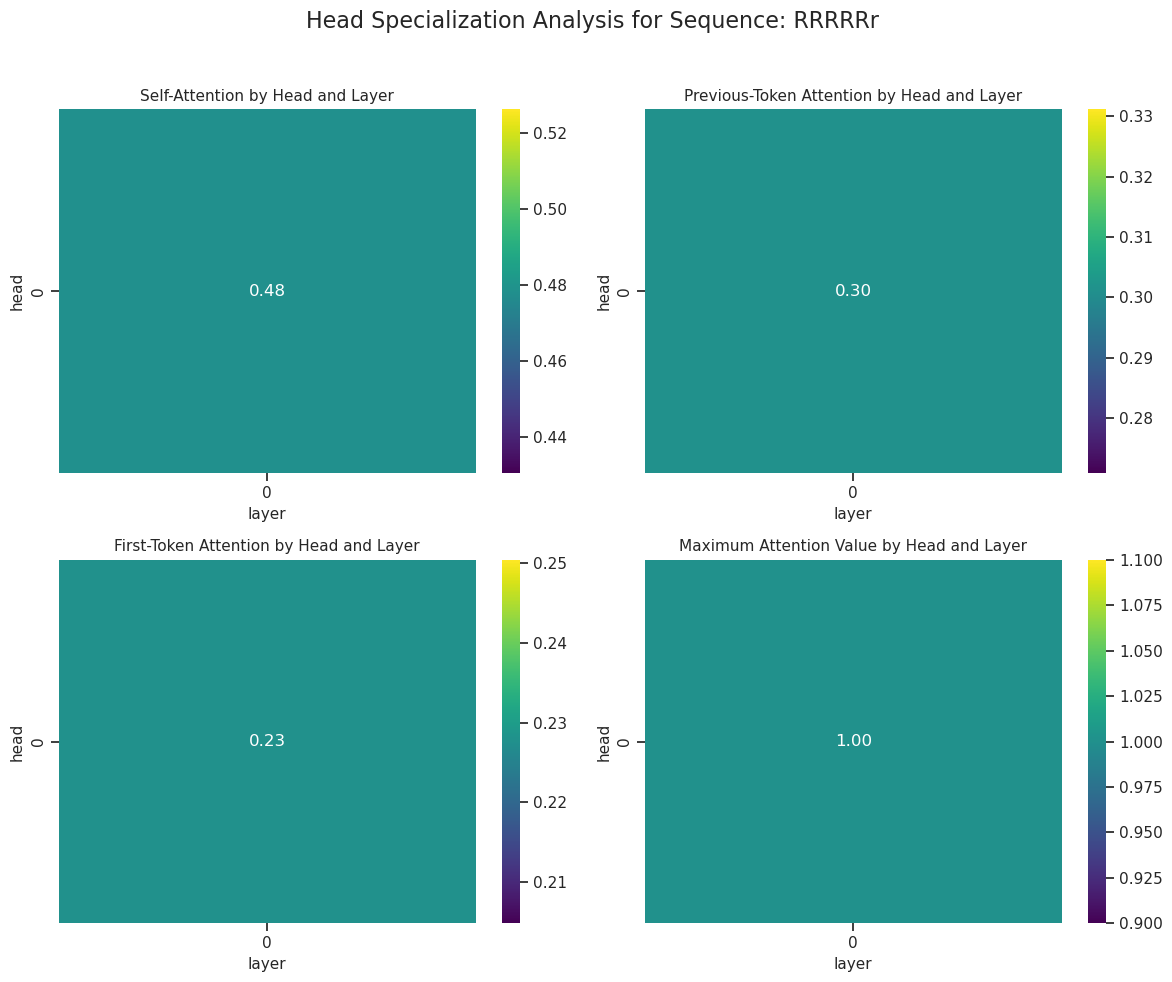


Top specialization patterns for sequence 'RRRRRr':
   layer  head  max_attention max_attention_pos
0      0     0            1.0            (0, 0)

Analyzing sequence 4/5: RRRRrR


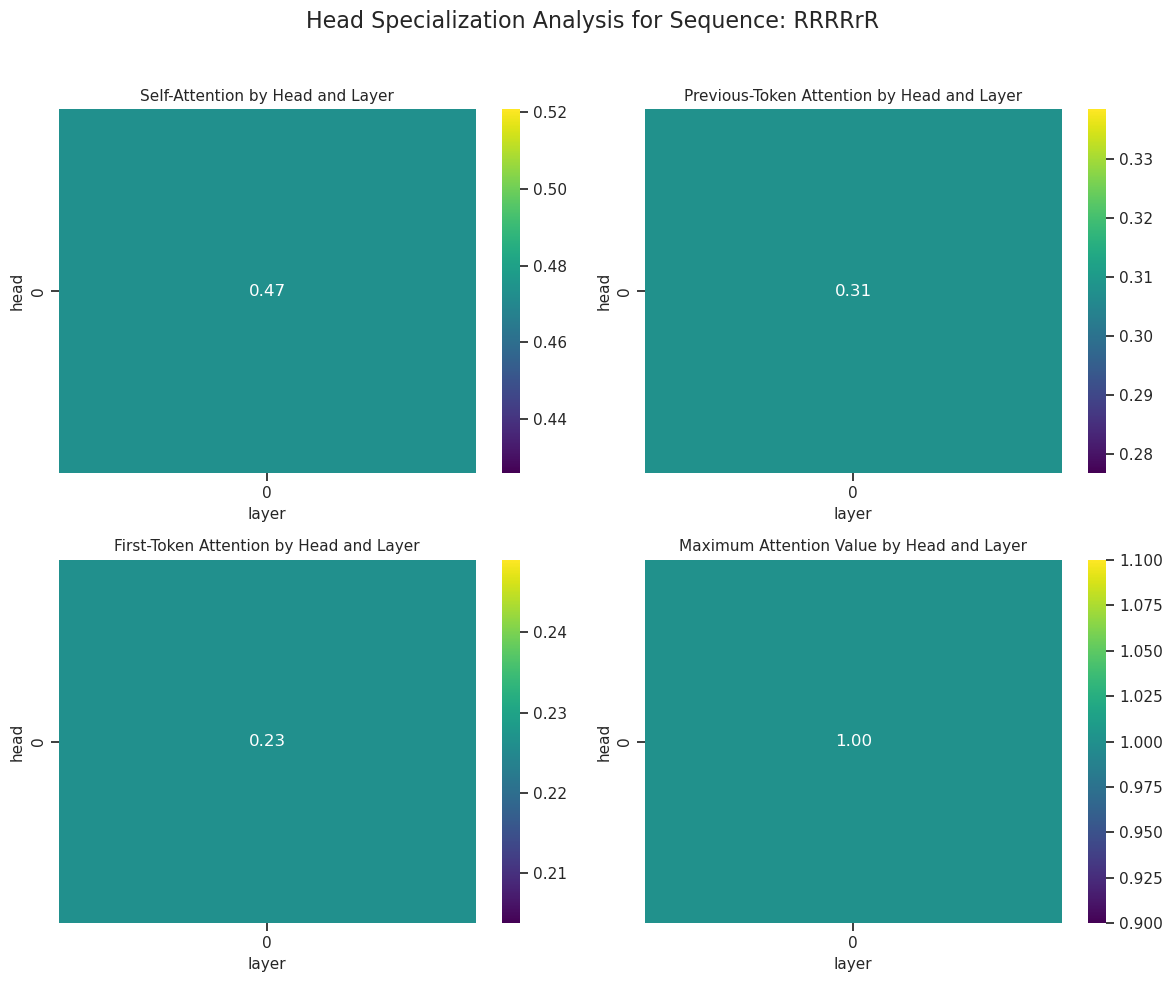


Top specialization patterns for sequence 'RRRRrR':
   layer  head  max_attention max_attention_pos
0      0     0            1.0            (0, 0)

Analyzing sequence 5/5: RRRrRR


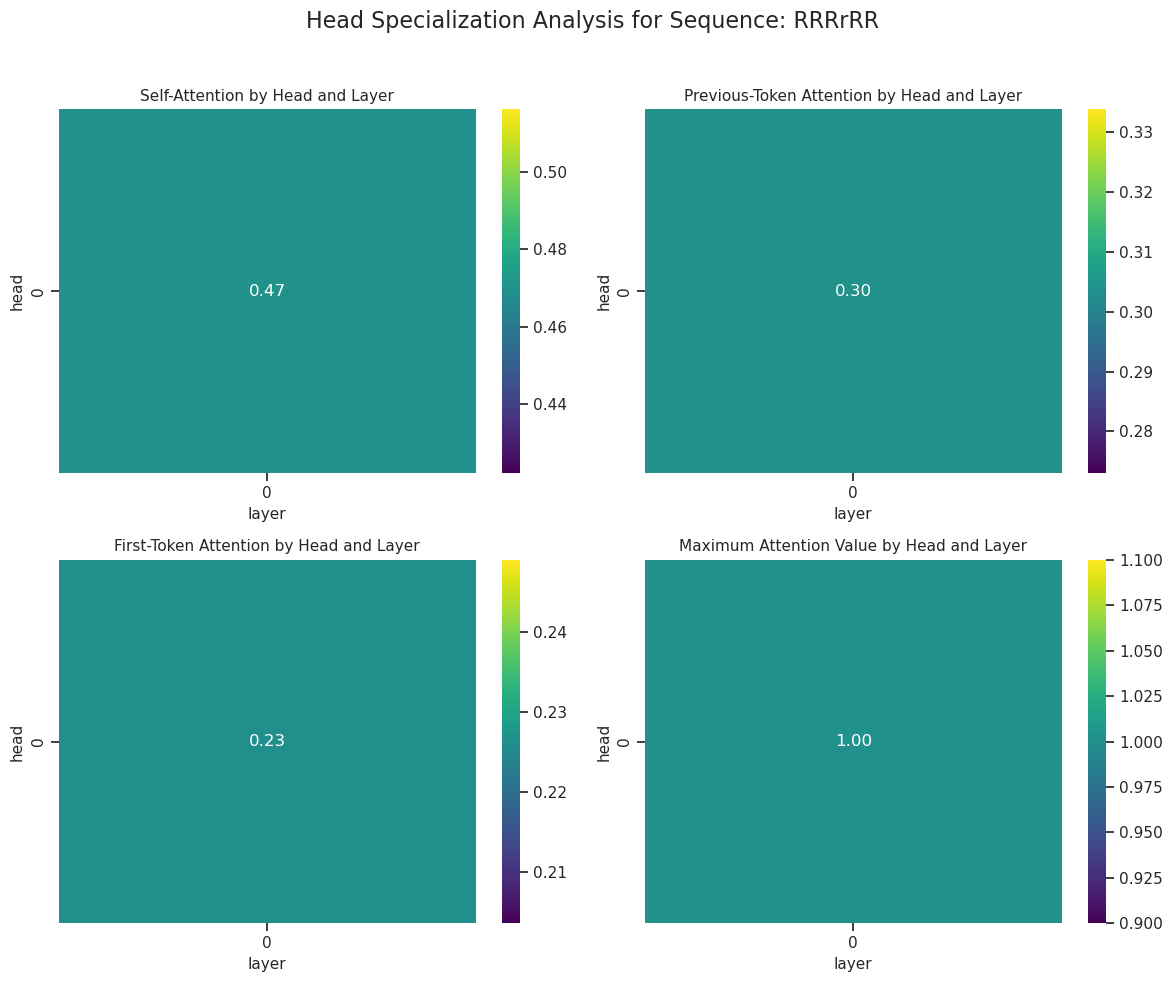


Top specialization patterns for sequence 'RRRrRR':
   layer  head  max_attention max_attention_pos
0      0     0            1.0            (0, 0)


In [15]:

def analyze_head_specialization(sequence):
    """Analyze how different heads specialize in different patterns"""
    # Encode the sequence
    input_ids = encode_sequence(sequence, stoi)
    
    # Get attention maps
    attention_maps = get_attention_maps(model, input_ids)
    
    # Analysis metrics for each head
    results = []
    
    for layer_idx, att_map in enumerate(attention_maps):
        n_heads = att_map.shape[1]
        
        for head_idx in range(n_heads):
            # Get attention matrix for this head
            att = att_map[0, head_idx]
            
            # Calculate attention to self (diagonal)
            self_attention = np.mean(np.diag(att))
            
            # Calculate attention to previous token
            prev_attention = 0
            for i in range(1, len(sequence)):
                prev_attention += att[i, i-1]
            prev_attention /= (len(sequence) - 1) if len(sequence) > 1 else 1
            
            # Calculate attention to first token
            first_attention = np.mean(att[1:, 0]) if len(sequence) > 1 else 0
            
            # Calculate maximum attention focus
            max_attention = np.max(att)
            i, j = np.unravel_index(np.argmax(att), att.shape)
            max_attention_pos = (i, j)
            
            # Store results
            results.append({
                'layer': layer_idx,
                'head': head_idx,
                'self_attention': self_attention,
                'prev_attention': prev_attention,
                'first_attention': first_attention,
                'max_attention': max_attention,
                'max_attention_pos': max_attention_pos
            })
    
    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(results)
    
    # Plot the specialization patterns
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'Head Specialization Analysis for Sequence: {sequence}', fontsize=16)
    
    # Plot self-attention by head/layer
    pivot_self = df.pivot(index='head', columns='layer', values='self_attention')
    sns.heatmap(pivot_self, annot=True, fmt='.2f', cmap='viridis', ax=axes[0, 0])
    axes[0, 0].set_title('Self-Attention by Head and Layer')
    
    # Plot prev-token attention by head/layer
    pivot_prev = df.pivot(index='head', columns='layer', values='prev_attention')
    sns.heatmap(pivot_prev, annot=True, fmt='.2f', cmap='viridis', ax=axes[0, 1])
    axes[0, 1].set_title('Previous-Token Attention by Head and Layer')
    
    # Plot first-token attention by head/layer
    pivot_first = df.pivot(index='head', columns='layer', values='first_attention')
    sns.heatmap(pivot_first, annot=True, fmt='.2f', cmap='viridis', ax=axes[1, 0])
    axes[1, 0].set_title('First-Token Attention by Head and Layer')
    
    # Plot max attention by head/layer
    pivot_max = df.pivot(index='head', columns='layer', values='max_attention')
    sns.heatmap(pivot_max, annot=True, fmt='.2f', cmap='viridis', ax=axes[1, 1])
    axes[1, 1].set_title('Maximum Attention Value by Head and Layer')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    return fig, df

# Show the specialization data
top_sequences = common_sequences[:5]

for i, sequence in enumerate(top_sequences):
    print(f"\n==================================================")
    print(f"Analyzing sequence {i+1}/5: {sequence}")
    print(f"==================================================")
    fig, df = analyze_head_specialization(sequence)
    plt.show()
    
    # Optionally display the top specialization patterns for this sequence
    print(f"\nTop specialization patterns for sequence '{sequence}':")
    print(df.sort_values('max_attention', ascending=False).head(5)[['layer', 'head', 'max_attention', 'max_attention_pos']])

## 6. Linking Attention to Decision-Making


Analyzing attention patterns for sequences predicting 'R'
Number of sequences: 17
Example sequences: ['RRRRRR', 'RRRRRr', 'RRRRrR']


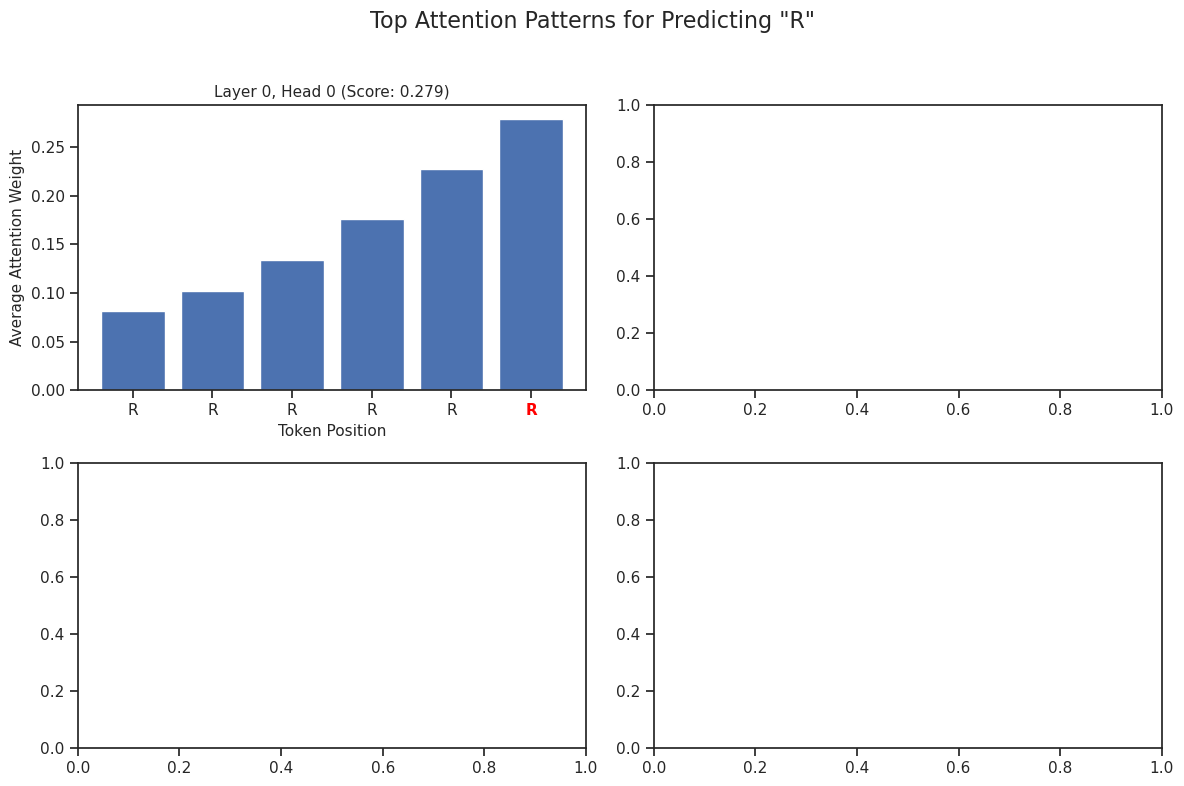


Analyzing attention patterns for sequences predicting 'L'
Number of sequences: 12
Example sequences: ['LLLLLL', 'RLLLLL', 'LLRLLL']


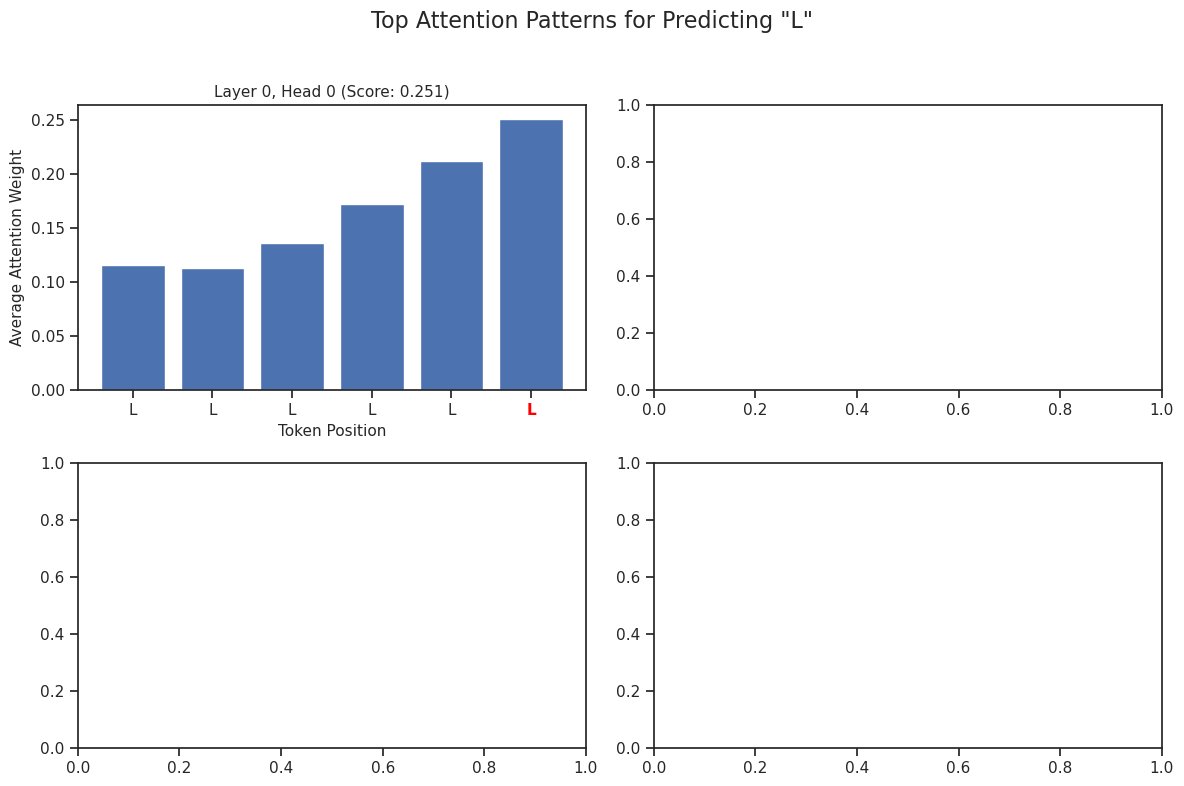


Analyzing attention patterns for sequences predicting 'r'
Number of sequences: 1
Example sequences: ['LLLLLR']


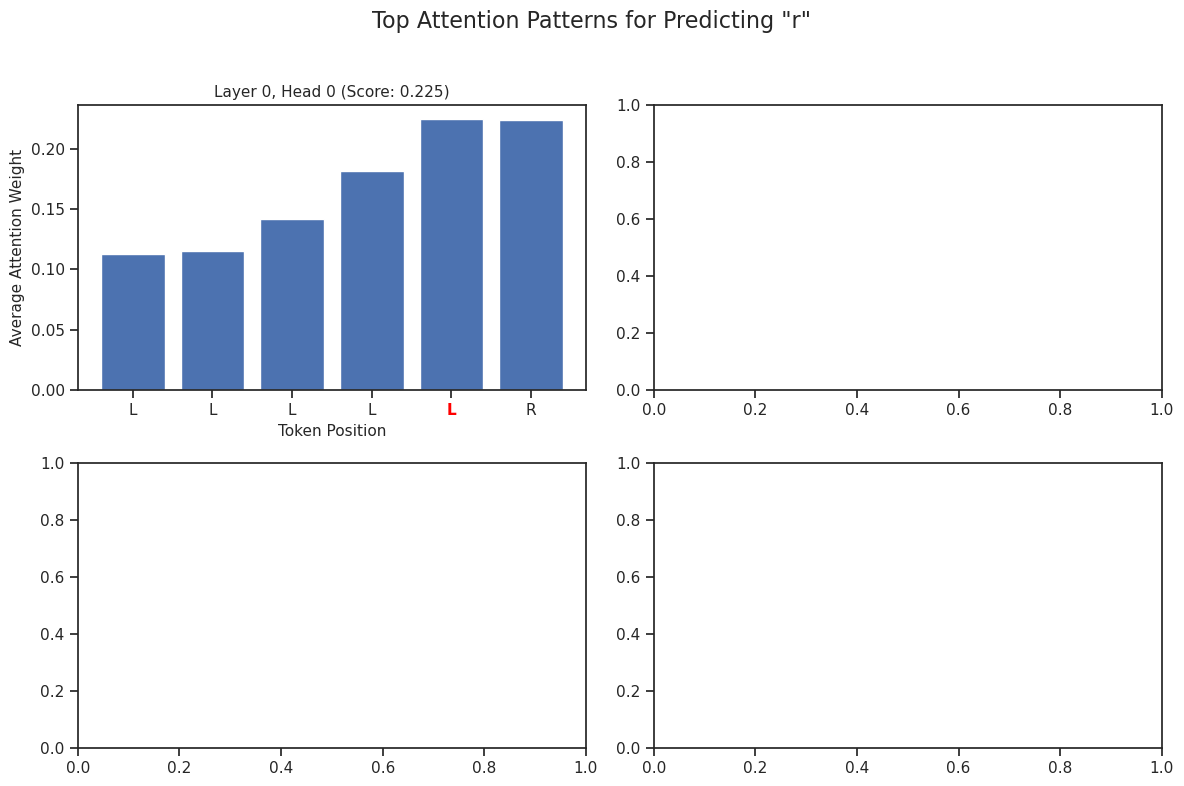


Most influential head/layer combinations for each decision outcome:

For predicting 'L':
   layer  head  max_attention  attended_position
1      0     0       0.251127                  5

For predicting 'R':
   layer  head  max_attention  attended_position
0      0     0       0.279176                  5

For predicting 'r':
   layer  head  max_attention  attended_position
2      0     0       0.224597                  4


In [13]:

def analyze_decision_making(sequences):
    """Analyze how attention patterns relate to decision outcomes"""
    # Group sequences by their next predicted token
    predictions = {}
    
    for seq in sequences:
        input_ids = encode_sequence(seq, stoi)
        probs = predict_next_token(model, input_ids)
        next_token = vocab[np.argmax(probs)]
        
        if next_token not in predictions:
            predictions[next_token] = []
        
        predictions[next_token].append({
            'sequence': seq,
            'attention_maps': get_attention_maps(model, input_ids),
            'probs': probs
        })
    
    # For each decision outcome, analyze common attention patterns
    results = []
    
    for next_token, sequences in predictions.items():
        print(f"\nAnalyzing attention patterns for sequences predicting '{next_token}'")
        print(f"Number of sequences: {len(sequences)}")
        print(f"Example sequences: {[s['sequence'] for s in sequences[:3]]}")
        
        
        # Calculate average attention for last token (the one before prediction)
        avg_last_token_attention = np.zeros((config.n_layer, config.n_head, len(sequences[0]['sequence'])))
        
        for seq_data in sequences:
            seq_len = len(seq_data['sequence'])
            
            for l in range(config.n_layer):
                for h in range(config.n_head):
                    # Get attention pattern for last token (which determines next prediction)
                    last_token_attention = seq_data['attention_maps'][l][0, h, seq_len-1, :seq_len]
                    avg_last_token_attention[l, h, :seq_len] += last_token_attention
        
        # Average across all sequences with this prediction
        avg_last_token_attention /= len(sequences)
        
        # Find most influential heads/layers for this decision
        for l in range(config.n_layer):
            for h in range(config.n_head):
                # Get max attention and its position
                max_att = np.max(avg_last_token_attention[l, h])
                max_pos = np.argmax(avg_last_token_attention[l, h])
                
                results.append({
                    'next_token': next_token,
                    'layer': l,
                    'head': h,
                    'max_attention': max_att,
                    'attended_position': max_pos,
                    'attended_tokens': [s['sequence'][max_pos] for s in sequences[:5] if max_pos < len(s['sequence'])]
                })
        
        # Visualize average attention for top heads
        top_combinations = sorted(
            [(l, h, np.max(avg_last_token_attention[l, h])) for l in range(config.n_layer) for h in range(config.n_head)],
            key=lambda x: x[2], reverse=True
        )[:4]  # Top 4 head/layer combinations
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        axes = axes.flatten()
        
        for i, (l, h, score) in enumerate(top_combinations[:4]):
            if i < len(axes):
                # Example sequence for visualization
                example_seq = sequences[0]['sequence']
                
                # Plot average attention pattern
                att_pattern = avg_last_token_attention[l, h, :len(example_seq)]
                ax = axes[i]
                ax.bar(range(len(example_seq)), att_pattern)
                ax.set_xticks(range(len(example_seq)))
                ax.set_xticklabels(list(example_seq))
                ax.set_title(f'Layer {l}, Head {h} (Score: {score:.3f})')
                ax.set_xlabel('Token Position')
                ax.set_ylabel('Average Attention Weight')
                
                # Highlight the max attention position
                max_pos = np.argmax(att_pattern)
                ax.get_xticklabels()[max_pos].set_color('red')
                ax.get_xticklabels()[max_pos].set_fontweight('bold')
        
        plt.suptitle(f'Top Attention Patterns for Predicting "{next_token}"', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
    
    # Convert results to DataFrame for analysis
    df_results = pd.DataFrame(results)
    
    return df_results

# Get a set of sequences for analysis
analysis_sequences = vc[vc > 50].index.tolist()[:30]  # Top 10 common sequences

# Run the analysis
decision_analysis = analyze_decision_making(analysis_sequences)

# Show summary of results
print("\nMost influential head/layer combinations for each decision outcome:")
for token in sorted(decision_analysis['next_token'].unique()):
    token_df = decision_analysis[decision_analysis['next_token'] == token].sort_values('max_attention', ascending=False)
    top_combinations = token_df[['layer', 'head', 'max_attention', 'attended_position']].head(3)
    print(f"\nFor predicting '{token}':")
    print(top_combinations)

# 7. Compare Head Specialization Depending on Decision Outcomes


Analyzing head specialization for outcome: R


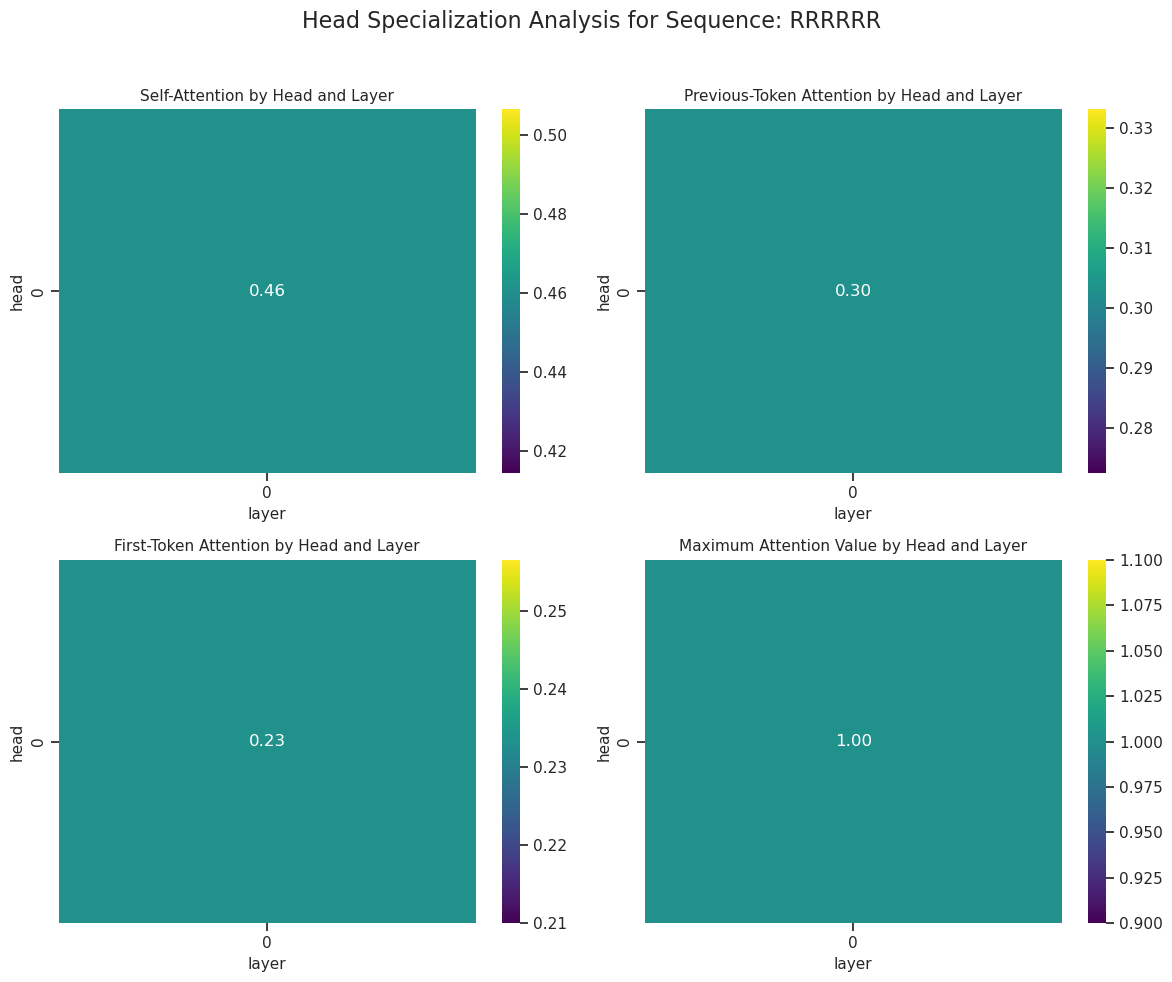

Top specialized heads for outcome 'R':
   layer  head  max_attention max_attention_pos
0      0     0            1.0            (0, 0)

Analyzing head specialization for outcome: L


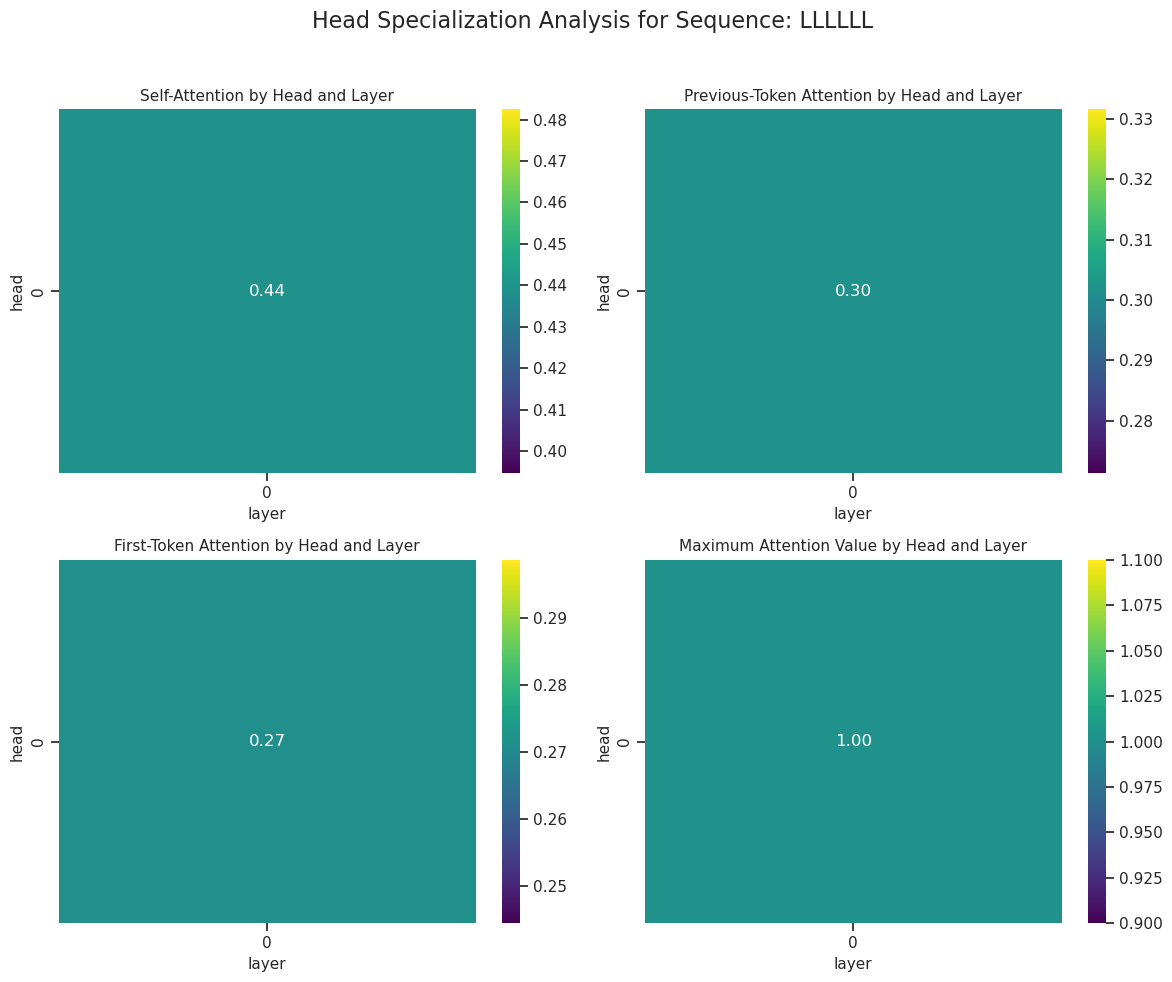

Top specialized heads for outcome 'L':
   layer  head  max_attention max_attention_pos
0      0     0            1.0            (0, 0)

Analyzing head specialization for outcome: r


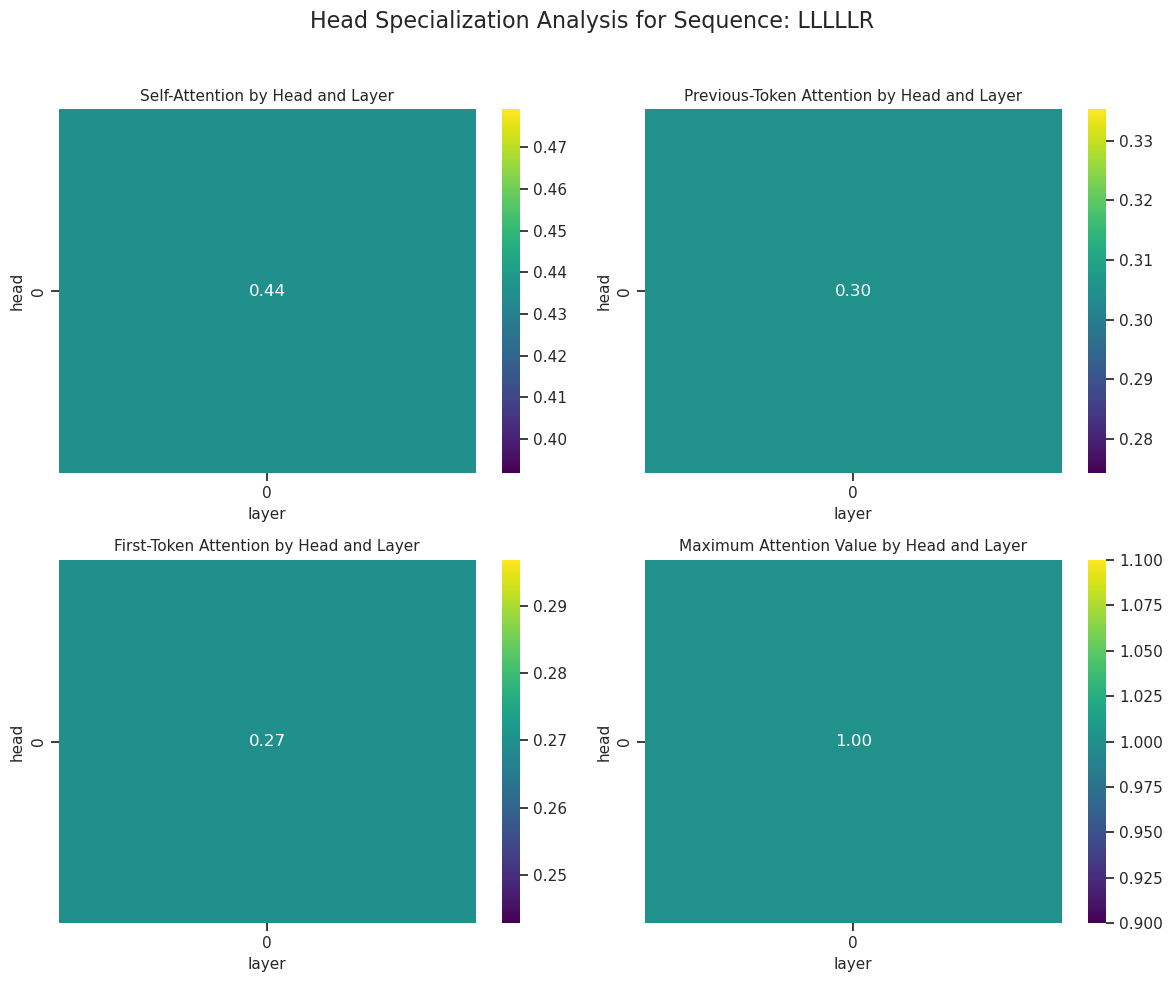

Top specialized heads for outcome 'r':
   layer  head  max_attention max_attention_pos
0      0     0            1.0            (0, 0)


In [16]:
# Group sequences by their predicted next token
outcome_sequences = {}
for seq in common_sequences[:20]:  # Use more sequences for better analysis
    input_ids = encode_sequence(seq, stoi)
    probs = predict_next_token(model, input_ids)
    next_token = vocab[np.argmax(probs)]
    
    if next_token not in outcome_sequences:
        outcome_sequences[next_token] = []
    outcome_sequences[next_token].append(seq)

# For each decision outcome, analyze head specialization
for outcome, sequences in outcome_sequences.items():
    if len(sequences) > 0:
        print(f"\n{'='*50}")
        print(f"Analyzing head specialization for outcome: {outcome}")
        print(f"{'='*50}")
        example_seq = random.choice(sequences)
        fig, df = analyze_head_specialization(example_seq)
        plt.show()
        
        # Identify specialized heads for this outcome
        top_heads = df.sort_values('max_attention', ascending=False)[['layer', 'head', 'max_attention', 'max_attention_pos']].head(3)
        print(f"Top specialized heads for outcome '{outcome}':")
        print(top_heads)

# 8. Comparing Attention at Critical Positions

R
max_attention_pos
5    28
4     7
Name: count, dtype: int64
L
max_attention_pos
5    37
4    14
Name: count, dtype: int64
r
max_attention_pos
5    7
4    6
Name: count, dtype: int64
l
max_attention_pos
5    1
Name: count, dtype: int64


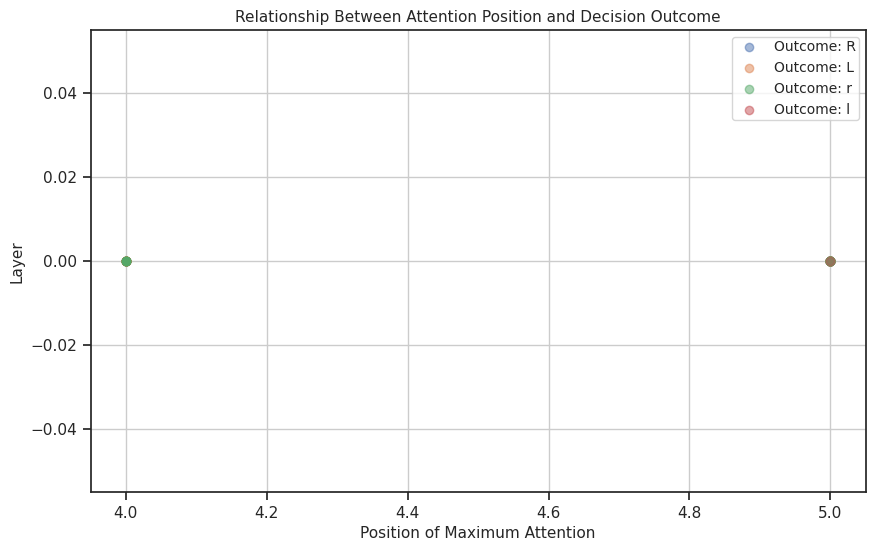

In [25]:
# Analyze attention to specific positions across different decisions
def analyze_positional_attention(sequences, position_idx=-1):
    """Analyze how attention to specific positions affects decisions"""
    position_data = []
    
    for seq in sequences:
        input_ids = encode_sequence(seq, stoi)
        attention_maps = get_attention_maps(model, input_ids)
        probs = predict_next_token(model, input_ids)
        next_token = vocab[np.argmax(probs)]
        
        # Extract attention at the specified position
        for l in range(len(attention_maps)):
            for h in range(attention_maps[l].shape[1]):
                # Get attention from the last token to all positions
                att_pattern = attention_maps[l][0, h, -1, :]
                
                position_data.append({
                    'sequence': seq,
                    'next_token': next_token,
                    'layer': l,
                    'head': h,
                    'attention_scores': att_pattern.tolist(),
                    'max_attention_pos': np.argmax(att_pattern)
                })
    
    # Convert to DataFrame
    df = pd.DataFrame(position_data)
    return df

# Run position analysis
#top 100 common sequences
position_df = analyze_positional_attention(vc[vc > 50].index.tolist()[:100])

# Visualize relationship between attention position and decision
plt.figure(figsize=(10, 6))
for token in position_df['next_token'].unique():
    token_df = position_df[position_df['next_token'] == token]
    print(token)
    print(token_df['max_attention_pos'].value_counts())
    plt.scatter(token_df['max_attention_pos'], token_df['layer'], 
                label=f"Outcome: {token}", alpha=0.5)
    # Print token and position of maximum attention
plt.xlabel('Position of Maximum Attention')
plt.ylabel('Layer')
plt.title('Relationship Between Attention Position and Decision Outcome')
plt.legend()
plt.grid(True)
plt.show()

# 9. Distinctive Attention Patterns by Decision

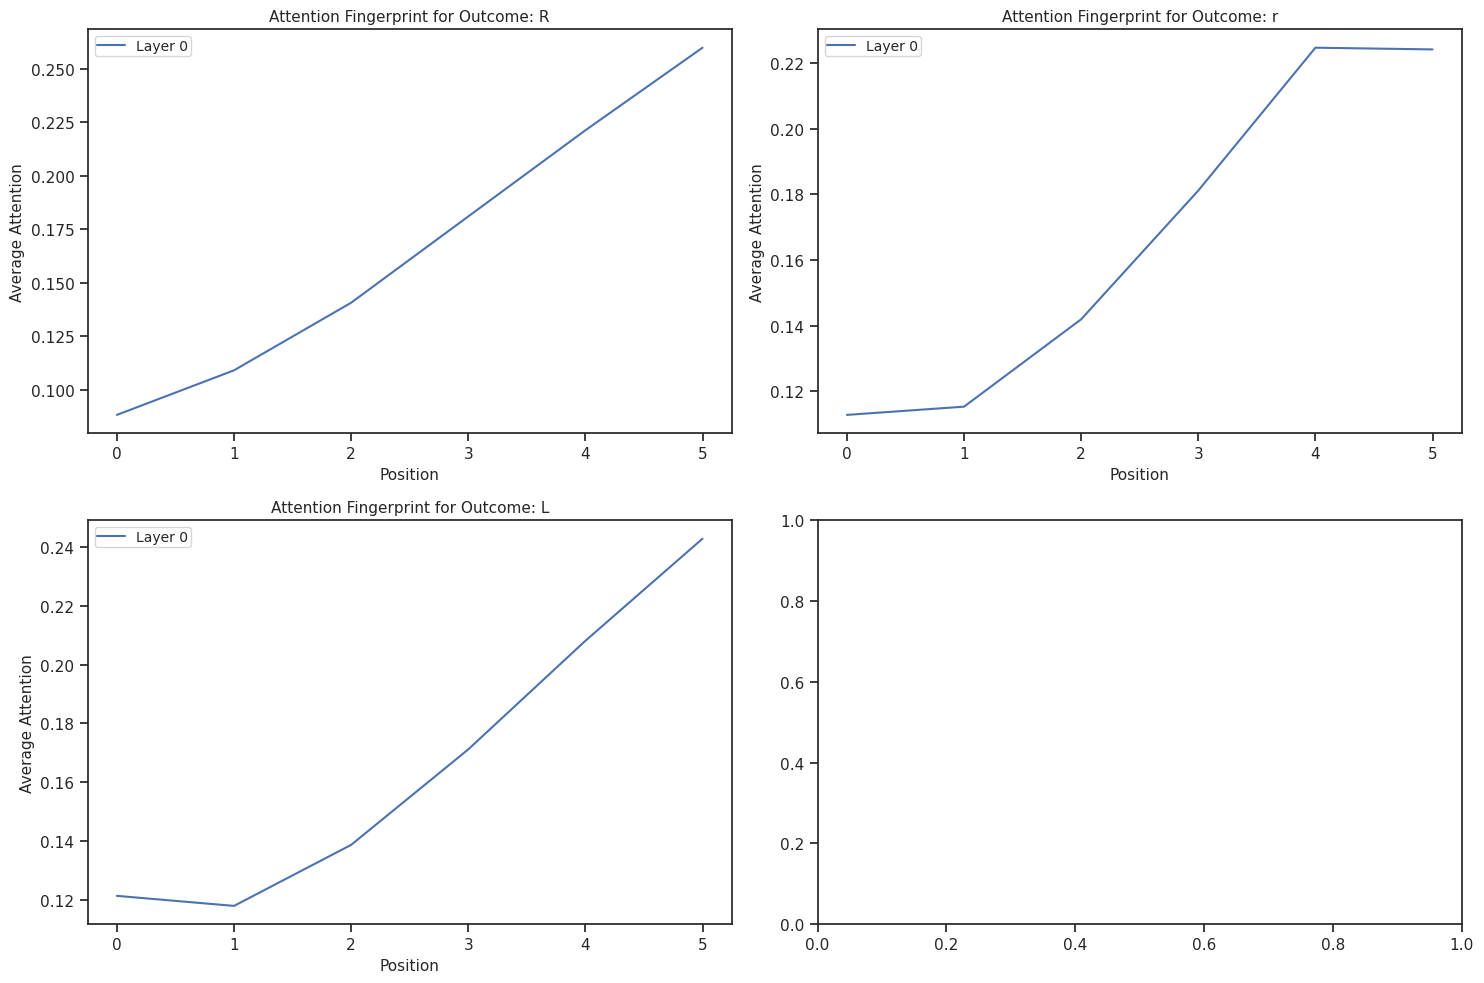

In [26]:
# For each sequence, get layer-wise attention patterns
def get_attention_fingerprint(sequences):
    fingerprints = []
    
    for seq in sequences:
        input_ids = encode_sequence(seq, stoi)
        attention_maps = get_attention_maps(model, input_ids)
        probs = predict_next_token(model, input_ids)
        next_token = vocab[np.argmax(probs)]
        
        # Get attention from last token to all positions for each layer
        layer_patterns = []
        for l in range(len(attention_maps)):
            # Average across heads
            avg_pattern = np.mean([attention_maps[l][0, h, -1, :] for h in range(attention_maps[l].shape[1])], axis=0)
            layer_patterns.append(avg_pattern)
        
        fingerprints.append({
            'sequence': seq,
            'next_token': next_token,
            'layer_patterns': layer_patterns
        })
    
    return fingerprints

# Run fingerprint analysis
fingerprints = get_attention_fingerprint(common_sequences[:100])

# Visualize attention fingerprints by decision type
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, token in enumerate(vocab):
    if i < len(axes):
        ax = axes[i]
        token_fingerprints = [f for f in fingerprints if f['next_token'] == token]
        
        if token_fingerprints:
            # Plot average attention pattern across layers
            for l in range(len(token_fingerprints[0]['layer_patterns'])):
                layer_data = [f['layer_patterns'][l] for f in token_fingerprints]
                avg_pattern = np.mean(np.array([p[:len(min(layer_data, key=len))] for p in layer_data]), axis=0)
                ax.plot(range(len(avg_pattern)), avg_pattern, label=f'Layer {l}')
            
            ax.set_title(f'Attention Fingerprint for Outcome: {token}')
            ax.set_xlabel('Position')
            ax.set_ylabel('Average Attention')
            ax.legend()

plt.tight_layout()
plt.show()

# 10. Analysis between close decisions 'Competing choices'


Comparing sequences with 83.33% similarity but different outcomes:
Sequence 1: LLLLLL → L
Sequence 2: LLLLLR → r
Sequence: LLLLLL → Predicted next token: L
Sequence: LLLLLR → Predicted next token: r


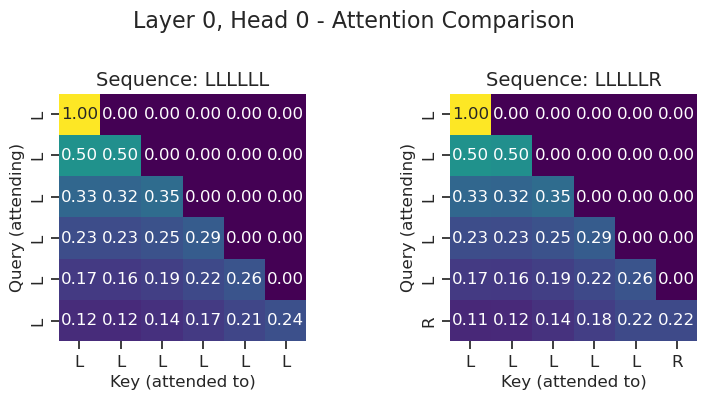


Comparing sequences with 83.33% similarity but different outcomes:
Sequence 1: LLLLLR → r
Sequence 2: LLLLLL → L
Sequence: LLLLLR → Predicted next token: r
Sequence: LLLLLL → Predicted next token: L


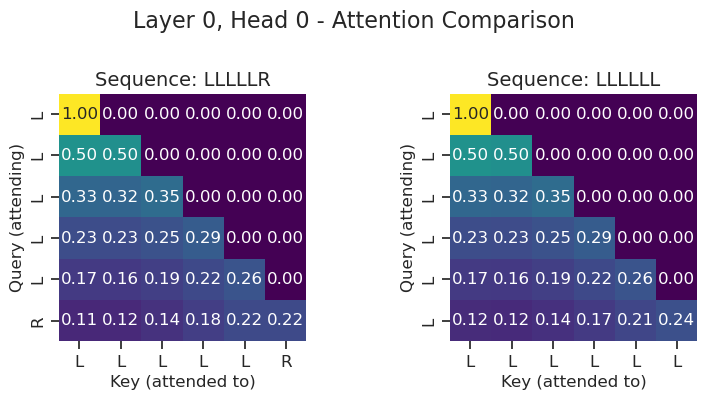


Comparing sequences with 66.67% similarity but different outcomes:
Sequence 1: LLLLLR → r
Sequence 2: RLLLLL → L
Sequence: LLLLLR → Predicted next token: r
Sequence: RLLLLL → Predicted next token: L


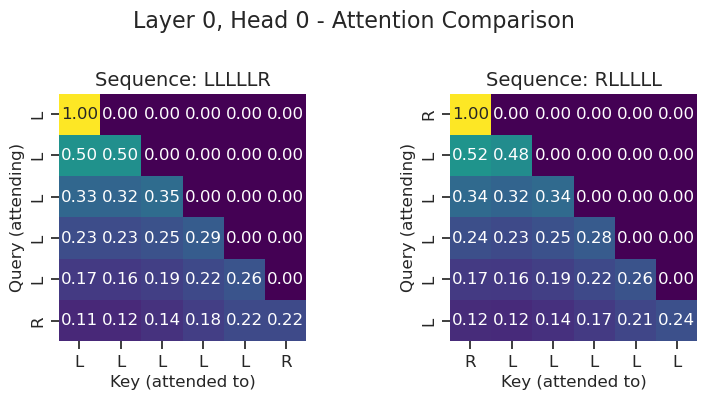


Comparing sequences with 66.67% similarity but different outcomes:
Sequence 1: RLLLLL → L
Sequence 2: LLLLLR → r
Sequence: RLLLLL → Predicted next token: L
Sequence: LLLLLR → Predicted next token: r


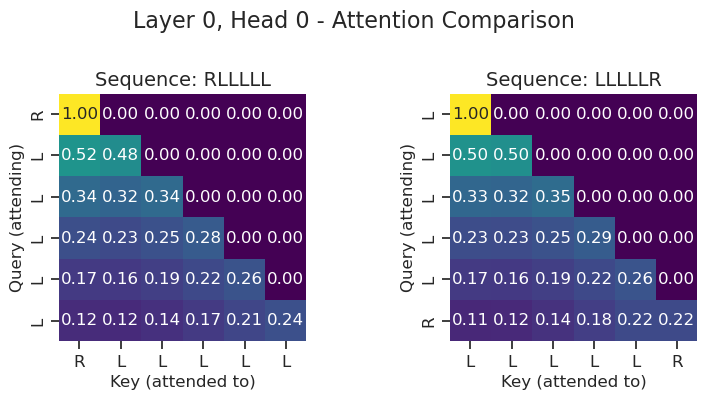

In [23]:
# Select sequences that result in different decisions but are similar
def find_critical_sequences():
    critical_pairs = []
    
    for i, seq1 in enumerate(common_sequences[:20]):
        input_ids1 = encode_sequence(seq1, stoi)
        probs1 = predict_next_token(model, input_ids1)
        next_token1 = vocab[np.argmax(probs1)]
        
        for j, seq2 in enumerate(common_sequences[:20]):
            if i != j:
                input_ids2 = encode_sequence(seq2, stoi)
                probs2 = predict_next_token(model, input_ids2)
                next_token2 = vocab[np.argmax(probs2)]
                
                # If decisions differ but sequences are similar
                if next_token1 != next_token2:
                    # Calculate sequence similarity
                    similarity = sum(1 for a, b in zip(seq1, seq2) if a == b) / max(len(seq1), len(seq2))
                    if similarity > 0.5:  # If sequences are at least 50% similar
                        critical_pairs.append((seq1, seq2, next_token1, next_token2, similarity))
    
    # Sort by similarity
    critical_pairs.sort(key=lambda x: x[4], reverse=True)
    return critical_pairs[:5]  # Return top 5 most similar pairs with different outcomes

# Find and analyze critical sequence pairs
critical_pairs = find_critical_sequences()

# Compare attention patterns for critical pairs
for seq1, seq2, token1, token2, similarity in critical_pairs:
    print(f"\nComparing sequences with {similarity:.2%} similarity but different outcomes:")
    print(f"Sequence 1: {seq1} → {token1}")
    print(f"Sequence 2: {seq2} → {token2}")
    
    # Compare attention patterns for this pair in a few specific layers/heads
    compare_attention_for_sequences([seq1, seq2], layer_idx=0, head_idx=0)
    plt.show()

## 11. Summary of Findings

Some interesting preliminary results
- Pays more attention to misses. 
- Layers make it hard to interpret